I haven't played a game of Magic in over 15 years, but every now and then I keep up with what's going on with this unique trading card game. If you don't know this game, see [wikipedia](https://en.wikipedia.org/wiki/Magic:_The_Gathering.) for an introduction. This is a rich game, with interesting mathematics and game theory to explore both in the game itself (explored by many, notably Frank Karsten, for example [here](https://www.channelfireball.com/articles/frank-analysis-how-many-colored-mana-sources-do-you-need-to-consistently-cast-your-spells/)), and in the so-called _metagame_. In this post, I simulate some fictional metagames to better understand the dynamics at play. Read on for an introductory explanation of what is meant by that. 

![black_lotus](http://assets.dacw.co/itemimages/58774.jpg)

<center>
    <i>Black Lotus, the most iconic and most expensive card in the history of Magic. It was printed in 1993, and an original printing of this card, if found, will cost you approximately $50000</i>
</center>

## What is the _metagame_

In _Magic: The Gathering_, players choose 60 cards of an available card pool to create a 'deck'. The total number of unique cards printed for this game exceeds 16k at the moment, and they are grouped into _formats_, that are limiting the card choices for the deck. Some formats allow almost every card to be selected for a deck (ie. _Vintage_), and some formats are designed to keep up with only recent sets (ie. _Standard_). Even from a relatively small card pool, a small format, the number of unique decks you can select is practically infinite. You can have up to 4 copies of a card in your deck, so the number of unique decks in a format with 1000 cards is equal to the number below. 

In [1]:
from scipy.special import comb

n = comb(1000 * 4, 60)
int(n)

102397487939804847334879764234818876475189535653317937436098836971331870810446508774476664825686816419995102261442215959891370838065152

In practice however, in particular for tournaments, players figure out typical cards that go well together and it makes sense to think of the decks people use as belonging to different _archetypes_. These are more or less defined card selections, where people tweak little things to their personal taste, but the overall strategy and most of the cards remain the same. At the time of writing, there are about 30 archetypes in  _Modern_ format that make up the majority of decks that people select for tournaments. New archetypes go in and out of fashion all the time, so this number, and the exact lists used, changes all the time. Choosing an archetype is an important part of tournament play in this game. Different archetypes all have unique matchups to the other archetypes. For example in the "Modern" format, the "Spirits" archetype is know to match up badly against the "Red Phoenix" archetype. Still, a lot of players choose to play with a "Spirits" deck, because, across the field, "Spirits" is well-positioned. You can read [this](https://www.channelfireball.com/articles/the-ghosts-of-portland-massive-modern-matchup-analysis/) to get a sense of how this works for a recent tournament. The dynamic of choosing an archetype, based on what archetypes you expect to play and how they match up against each other, is known as the metagame. 

Magic players typically enjoy this part of the game, in particular when the format is dynamic, so when the share of the different archetypes is changing all the time, and players don't know exactly what the strongest deck is. Sometimes, a specific archetype is known to be basically the strongest for a specific format, and everyone will mostly play that archetype simply because it's the only way to win a tournament. In other cases, there is a fixed mix of archetypes that are relevant in the format and the share of each deck doesn't really change. In both cases, the format is called _stale_ , or _solved_, and players tend to be less excited about playing in such formats. Formats are then typically changed because new cards are printed, and sometimes specific cards are banned from playing to cripple a dominating archetype. 

The company that produces Magic: The Gathering cards, sets rules and bannings and also controls many events and the online play, is known to restrict the availability of data on decklists and matchup results. This makes sense, because they want the formats to stay dynamic and prevent the players from too easily solving them. But the statistics are interesting, so I have been looking to do some analysis anyway. Recently, Tobi Henke gathered some high-quality data, ([see here](https://www.channelfireball.com/articles/the-ghosts-of-portland-massive-modern-matchup-analysis/)), and I have been modelling the metagame dynamics based on that dataset. In this first post on the topic, I will actually not use any real data, and only model some fictional metagames to explore the dynamics of them. 

The post will include the code used to generate the simulations, but in between I have included text and you can just skip over the code bits and look at the text and the graphs if that's the interesting part for you. For simplification I am omitting several things, such as sideboard strategies and adaptability of different archetypes. 

In [2]:
import scipy
from scipy import stats
import pandas as pd
import numpy as np

%pylab inline

## this is some code that allows axis labels to be formatted as percentages
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    return f'{int(y * 100)}%'

percent_formatter = FuncFormatter(to_percent)

Populating the interactive namespace from numpy and matplotlib


Here is our main model. We assume a fixed number of archetypes (I also call them simply "decks", the number is `n_decks`), with some known winning percentages over the other decks (`matchups`). The simulation is done by selecting the best deck based on the current share of each of the archetypes (`metashare`). 

In [3]:
class Meta(object):
    
    def __init__(self, metashare: np.array, matchups: np.array, stepsize: float = .01):
        
        self.metashare = metashare
        self.matchups = matchups
        self.stepsize = stepsize
        
        self.n_decks = len(metashare)
        
        # initialize the evolving meta
        self._metas = [self.metashare]
        
    @property
    def metas(self):
        # this is a convenience method to return a np.array instead of a list of arrays
        return np.vstack(self._metas)
    
    def choose_next_deck(self):
        ## choose the best deck according to win percentages in the current meta
        curr_meta = self._metas[-1]
        return np.argmax(self.matchups @ curr_meta)
        
    def step(self):
        ## copy the current meta, choose a new deck and update
        next_deck = self.choose_next_deck()
        new_meta = self._metas[-1].copy()
        new_meta[next_deck] += self.stepsize

        new_meta = (new_meta / np.sum(new_meta))
        self._metas.append(new_meta)
   
    def evolve(self, steps: int) -> np.array:
        ## evolve the metagame, return the full array of metagames
        
        for i in range(steps): self.step()
        return self.metas
    
    def randomize_start(self):
        
        ## convenience for evaluating the influence of starting metashares
        return self.__class__(self.__class__.random_start(self.n_decks), self.matchups)
    
    @staticmethod
    def random_start(n_decks: int) -> np.array:

        meta = np.abs(stats.norm().rvs(n_decks))
        return meta / np.sum(meta)

    @staticmethod
    def random_matchups(n_decks: int, sd: float = .5) -> np.array:
        
        ## generate a matrix with matchup probabilities
        m = stats.norm().rvs((n_decks, n_decks)) * sd
        
        ## transposing makes sure the matrix is skew-symmetrics
        ## we then use the logit to convert to probabilities
        return scipy.special.expit(m - m.T)
    
    @classmethod
    def random_init(cls, n_decks: int, sd: float = .5):
        ## this returns a new meta with randomly initialized share and matchups
        
        return cls(cls.random_start(n_decks), cls.random_matchups(n_decks, sd))

I am simulating fictional metagames with the `Meta.random_init` function. Below, I generate a single random meta, and show it's `metashare`, ie., at the starting point of the simulation, what percentage of the players are playing each deck. The decks are simply labelled 0, 1, 2, 3 and 4, amounting to 5 different archetypes in total. 

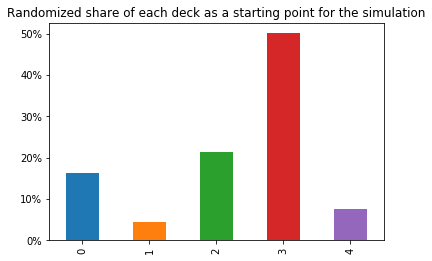

In [4]:
np.random.seed(42)
meta = Meta.random_init(5)
ax = pd.Series(meta.metashare).plot.bar()
ax.yaxis.set_major_formatter(percent_formatter)
plt.title("Randomized share of each deck as a starting point for the simulation");

There is also a matchup table generated for this fictional format, see the table below. This is intended to be read like "Deck 0 has a 74% probability to win over deck 1". Note that conversely, deck 1 has a 26% probability of winning over deck 0. This matrix is sort of anti-symmetric, it is generated based on a [skew-symmetric](https://en.wikipedia.org/wiki/Skew-symmetric_matrix) matrix, for the mathematically enthousiastic readers. 

In [5]:
mu = pd.DataFrame(meta.matchups)
mu.style.format("{:.0%}")

,0,1,2,3,4
0,50%,74%,66%,28%,55%
1,26%,50%,65%,30%,43%
2,34%,35%,50%,38%,29%
3,72%,70%,62%,50%,51%
4,45%,57%,71%,49%,50%


Now for the simulation, we slightly change the starting archetype shares by increasing the share of the deck with the best winning percentages. We calculate the winning percentages, that are a combination of the current metagame share and the matrix of winning percentages above. To find the winning percentage, you multiply the probability of playing against a specific archetype and the probability of winning against that archetype. 

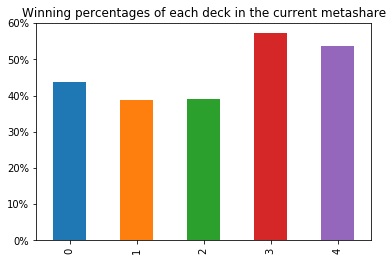

In [6]:
ax = pd.Series(meta.matchups @ meta.metashare).plot.bar()
ax.yaxis.set_major_formatter(percent_formatter)
plt.title("Winning percentages of each deck in the current metashare");

So in this fictional metagame, with the current distribution of archetypes, deck number 3 has the best probability of winning at slightly over 56%. The simulation is then based on the idea that players switch to this deck (in moderate amounts, governed by `step_size`). This in turn influences the winning percentages, increasing the relative attractiveness of deck 4 for example, that has the best winning probabilities against deck 3. The winning probabilities of each deck are recalculated, and the next best deck is bumped slightly, and so forth. 

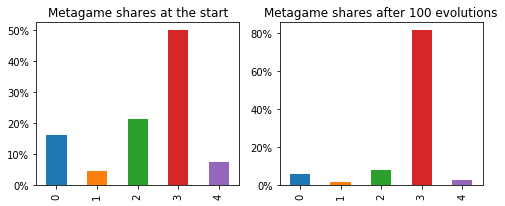

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (8, 3))

pd.Series(meta.metashare).plot.bar(ax = axes[0])
axes[0].set_title("Metagame shares at the start")
axes[0].yaxis.set_major_formatter(percent_formatter)

pd.Series(meta.evolve(steps = 100)[100, :]).plot.bar(ax = axes[1])
axes[1].set_title("Metagame shares after 100 evolutions")
axes[1].yaxis.set_major_formatter(percent_formatter)

Text(0.5,1,'Winning percentages after 100 evolutions')

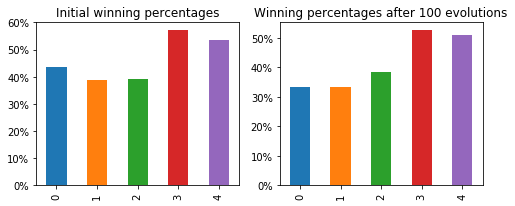

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (8, 3))

pd.Series(meta.matchups @ meta.metashare).plot.bar(ax = axes[0])
axes[0].yaxis.set_major_formatter(percent_formatter)
axes[0].set_title("Initial winning percentages");

pd.Series(meta.matchups @ meta.metas[100,:]).plot.bar(ax = axes[1])
axes[1].yaxis.set_major_formatter(percent_formatter)
axes[1].set_title("Winning percentages after 100 evolutions")

As you can see, as the format evolves, deck 3 is increasing it's dominance. From the matchup table, you can see that in this case, deck number 3 has a positive matchup against all other decks, so this makes sense. Now let's have a look at the long term propects of this fictional metagame. 

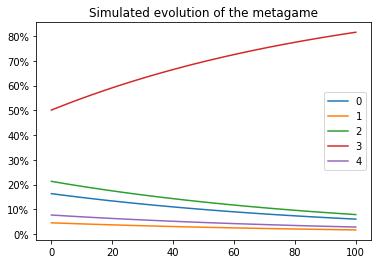

In [9]:
ax = pd.DataFrame(meta.metas).plot()
ax.yaxis.set_major_formatter(percent_formatter)
plt.title("Simulated evolution of the metagame");

As can be expected, this is not a very interesting metagame, as deck 3 just dominates every other deck. But this doesn't always happen, as the simulations below show. We simulate 200 evolution steps for 16 random metagames. As you can see, sometimes a dominating deck exists, but the dynamics can get interesting. 

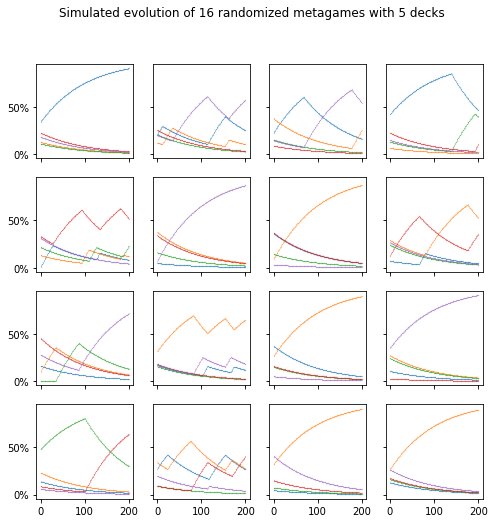

In [10]:
## a function to show the evolution of different metas in one plot

np.random.seed(1)
def show_simulated_metas(metas, steps):

    ncol = int(np.ceil(np.sqrt(len(metas))))
    nrow = int(np.ceil(len(metas) / ncol))
    
    f, axes = plt.subplots(nrow, ncol, sharey=True, sharex=True, figsize=(8, 8))

    for i, meta in enumerate(metas):

        row, col = i // ncol, i % ncol
        ax = axes[row, col]
        ax.yaxis.set_major_formatter(percent_formatter)
        pd.DataFrame(meta.evolve(steps)).plot(ax = ax, legend = False, style = ".", markersize = .3)
        
    return f
        
fig = show_simulated_metas([Meta.random_init(5) for i in range(16)], 200)
fig.suptitle("Simulated evolution of 16 randomized metagames with 5 decks");

For example, in the second plot on the first row, initially, blue seemed like a great deck, but then, as the share of each of the decks changed, the purple deck appeared even stronger. 

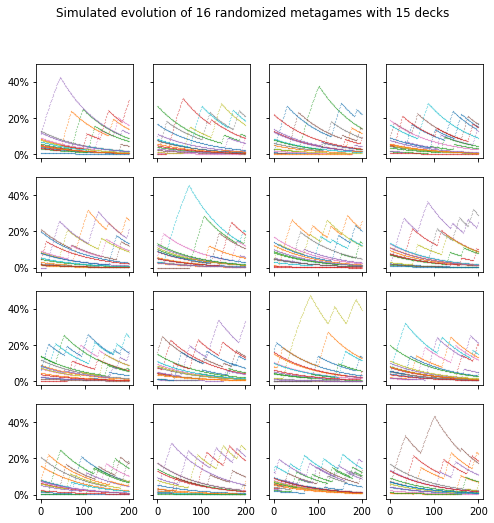

In [11]:
# in wide formats with many decks, the evolution is typically pretty chaotic
fig = show_simulated_metas([Meta.random_init(15) for i in range(16)], 200)
fig.suptitle("Simulated evolution of 16 randomized metagames with 15 decks");

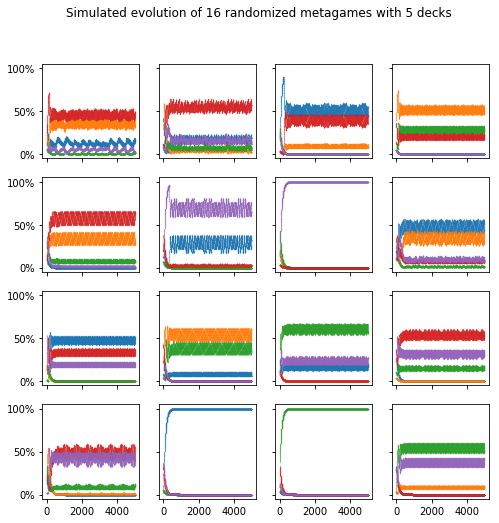

In [12]:
## here, we let the simulation run a little longer to see what the long term effects are
## after around 800 evolutions, a more or less solved format appears

fig = show_simulated_metas([Meta.random_init(5) for i in range(16)], 5000)
fig.suptitle("Simulated evolution of 16 randomized metagames with 5 decks");

As you can see in the previous plots, the simulated metagames take about 800 evolutions in this setup to stabilize. In a couple of cases, a single deck is dominating, but often, a couple of decks earn a share of the metagame. The behaviour can be quite chaotic, in particular in the last example, where this situation remains highly dynamic with some small perturbations even after setlling down. 

In these simulations, the starting metagame share is also randomized, but the long term dynamics are independent of this starting position, at least, thats what is looks like from the simulations below. 

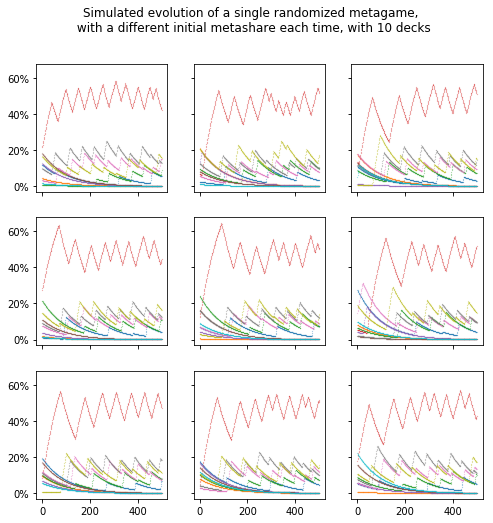

In [13]:
m = Meta.random_init(10)

fig = show_simulated_metas([m.randomize_start() for i in range(9)], 500)
fig.suptitle("Simulated evolution of a single randomized metagame, \n with a different initial metashare each time, with 10 decks");

Below, you can see just how chaotic the behaviour can get if we allow for many different archetypes, 25 in this case. After 2000 evolutions, a somewhat stable situation appears to be forming, for example, the yellow deck is clearly quite good, but there is no real convergence.  

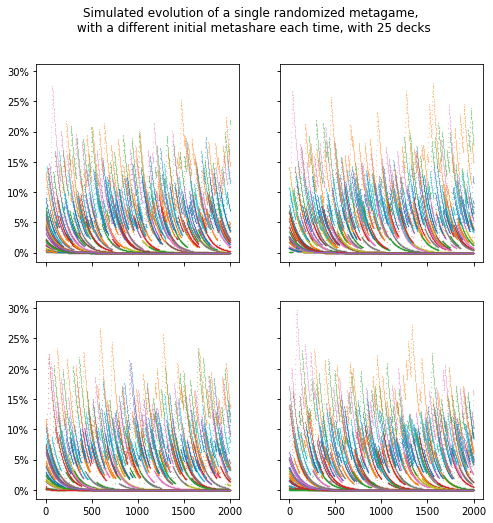

In [14]:
np.random.seed(1)
m = Meta.random_init(25)

fig = show_simulated_metas([m.randomize_start() for i in range(4)], 2000)
fig.suptitle("Simulated evolution of a single randomized metagame, \n with a different initial metashare each time, with 25 decks");

In the model above, we assumed that players switched to the best deck in a very rational way. As a first expansion of this model, I looked at the behaviour that emerges if we instead assume some randomization for choosing the next deck. The choice is based on the winning probabilities, but takes into account a `win_sensitivity` that will model players sometimes moving to a deck with lower winning percentages. This mimics a bit the exploration strategy used in Multi-Armed-Bandit problems (https://en.wikipedia.org/wiki/Multi-armed_bandit). 

In [15]:
class WinSensitiveMeta(Meta):
    def __init__(self, metashare, matchups, win_sensitivity):
        
        super().__init__(metashare, matchups)
        self.win_sensitivity = win_sensitivity
    
    def choose_next_deck(self):
        curr_meta = self._metas[-1]
        p = np.exp(self.matchups @ curr_meta * self.win_sensitivity)
        return np.random.choice(list(range(len(p))), p = p / np.sum(p))        
    
    @classmethod
    def random_init(cls, n_decks: int, win_sensitivity: float = 0, sd: float = .5):
        return cls(cls.random_start(n_decks), cls.random_matchups(n_decks, sd), win_sensitivity)

If the `win_sensitivity` is set to zero, players choose a deck randomly and the meta evolves randomly, with each deck fluctuating around a 20% share. 

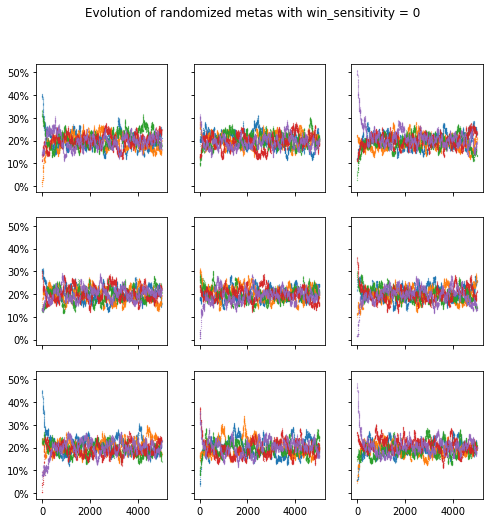

In [16]:
fig = show_simulated_metas([WinSensitiveMeta.random_init(n_decks=5, win_sensitivity=0) for i in range(9)], 5000);
fig.suptitle("Evolution of randomized metas with win_sensitivity = 0");

If we increase the `win_sensitivity` of the players, some dominating decks appear, but not as much as we saw before. If we increase the number of different decks, no deck ever goes above a 10% metagame share.  

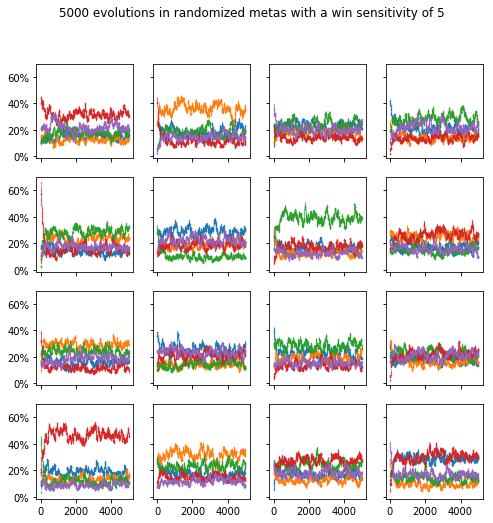

In [17]:
fig = show_simulated_metas([WinSensitiveMeta.random_init(n_decks=5, win_sensitivity=5) for i in range(16)], 5000);
fig.suptitle("5000 evolutions in randomized metas with a win sensitivity of 5");

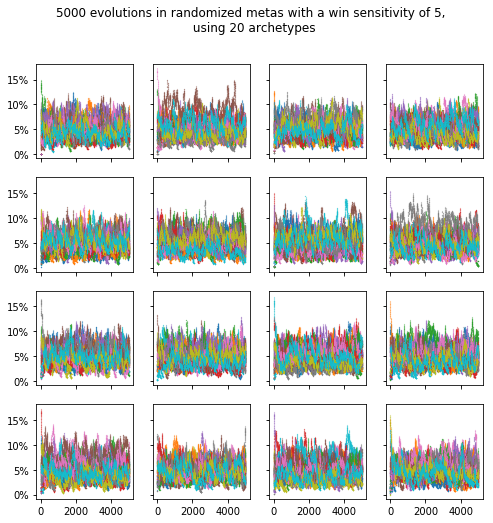

In [18]:
fig = show_simulated_metas([WinSensitiveMeta.random_init(n_decks=20, win_sensitivity=5) for i in range(16)], 5000);
fig.suptitle("5000 evolutions in randomized metas with a win sensitivity of 5, \n using 20 archetypes");

If we increase the `win_sensitivity` to 20, domination patterns start appearing again. Logically, it does take a lot more evolutions for these metagames to settle down. 

Text(0.5,0.98,'5000 evolutions in randomized metas with a win sensitivity of 20, \n using 5 archetypes')

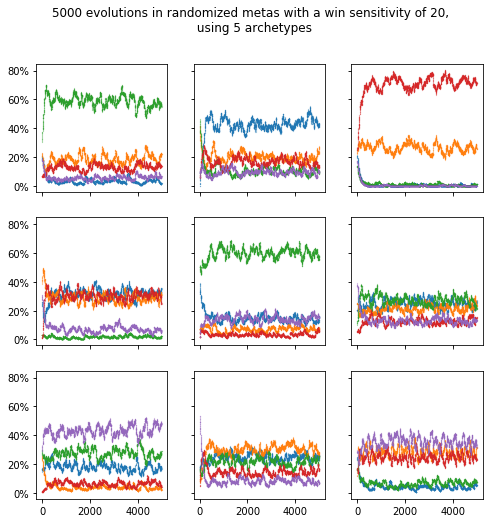

In [19]:
fig = show_simulated_metas([WinSensitiveMeta.random_init(n_decks=5, win_sensitivity=20) for i in range(9)], 5000);
fig.suptitle("5000 evolutions in randomized metas with a win sensitivity of 20, \n using 5 archetypes")

## Conclusion

This post explored dynamics of simulations of metagames in _Magic: the Gathering_. The behaviour, based on the simplifying assumptions I made, is really interesting to me and is often quite chaotic. Hopefully you enjoyed this exploration, and perhaps picked up some new knowledge on `python` or the game of _Magic_. I see a lot of avenues for further exploration from here. 

* For example, players do not only choose an archetype based on perceived winning percentages, but also based on the amount of money they have to spend to collect the cards needed. A price sensitivity could be integrated into this model. 
* I am also looking to calculate some winning probabilities based on real data from an actual format, and use the simulations as above to start predicting what will happen in that format. 